In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation

In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  23000
Storage of Prey Expert Buffer:  200000 



[PREDATOR] Epoch 01 | Train Loss: 0.680920 | Val Loss: 0.672794
[PREDATOR] Epoch 02 | Train Loss: 0.710242 | Val Loss: 0.887398
[PREDATOR] Epoch 03 | Train Loss: 0.618268 | Val Loss: 0.767267
[PREDATOR] Epoch 04 | Train Loss: 0.610295 | Val Loss: 0.582594
[PREDATOR] Epoch 05 | Train Loss: 0.472435 | Val Loss: 0.621629
[PREDATOR] Epoch 06 | Train Loss: 0.444590 | Val Loss: 0.402266
[PREDATOR] Epoch 07 | Train Loss: 0.427575 | Val Loss: 0.507145
[PREDATOR] Epoch 08 | Train Loss: 0.363107 | Val Loss: 0.360889
[PREDATOR] Epoch 09 | Train Loss: 0.496094 | Val Loss: 0.244634
[PREDATOR] Epoch 10 | Train Loss: 0.337958 | Val Loss: 0.571120
[PREDATOR] Epoch 11 | Train Loss: 0.409382 | Val Loss: 0.354939
[PREDATOR] Epoch 12 | Train Loss: 0.372948 | Val Loss: 0.307943
[PREDATOR] Epoch 13 | Train Loss: 0.455900 | Val Loss: 0.338118
[PREDATOR] Epoch 14 | Train Loss: 0.404714 | Val Loss: 0.155220
[PREDATOR] Epoch 15 | Train Loss: 0.347630 | Val Loss: 0.507193
[PREDATOR] Epoch 16 | Train Loss: 0.3780

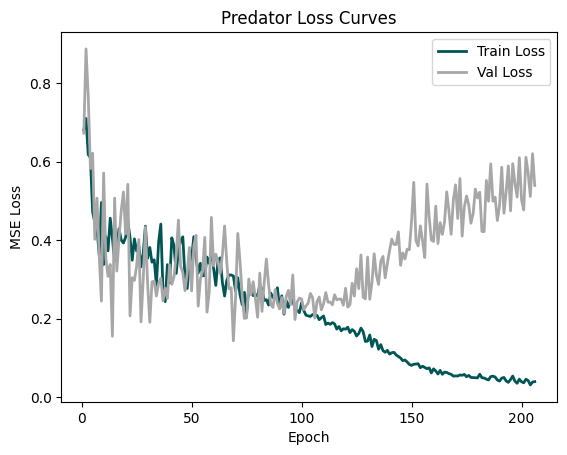

In [ ]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 0.470569 | Val Loss: 0.435822 | Pred Gain: 0.0004938456113450229
[PREY] Epoch 02 | Train Loss: 0.452276 | Val Loss: 0.457357 | Pred Gain: 0.00029475457267835736
[PREY] Epoch 03 | Train Loss: 0.450143 | Val Loss: 0.420126 | Pred Gain: 0.000701877404935658
[PREY] Epoch 04 | Train Loss: 0.443615 | Val Loss: 0.457628 | Pred Gain: 8.729196565582242e-07
[PREY] Epoch 05 | Train Loss: 0.439567 | Val Loss: 0.477002 | Pred Gain: 0.0006856110994704068
[PREY] Epoch 06 | Train Loss: 0.474483 | Val Loss: 0.430759 | Pred Gain: 0.00048523565055802464
[PREY] Epoch 07 | Train Loss: 0.450459 | Val Loss: 0.440312 | Pred Gain: 0.0006340242107398808
[PREY] Epoch 08 | Train Loss: 0.461721 | Val Loss: 0.466887 | Pred Gain: 0.0
[PREY] Epoch 09 | Train Loss: 0.462750 | Val Loss: 0.406050 | Pred Gain: 0.0006660607759840786
[PREY] Epoch 10 | Train Loss: 0.453788 | Val Loss: 0.447853 | Pred Gain: 0.0
[PREY] Epoch 11 | Train Loss: 0.452097 | Val Loss: 0.430311 | Pred Gain: 8.0823898315

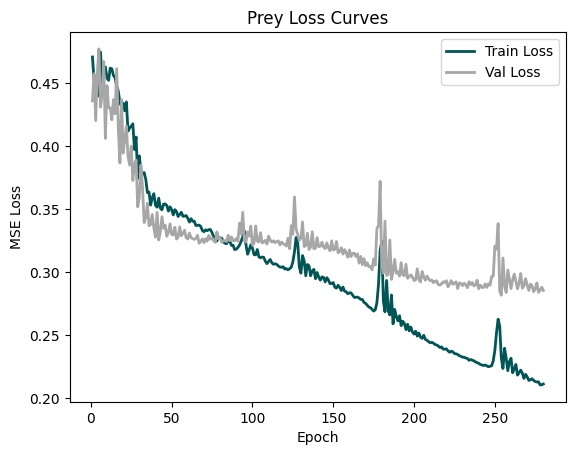

In [ ]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=1000, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

In [9]:
env = parallel_env(use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.
